## Interval Analysis

In [1]:
# !pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
# from tensorboardX import SummaryWriter

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class Net(nn.Sequential):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.final = nn.Linear(50, 10)

    def forward(self, x):
        x = (x - 0.1307)/0.3081
        x = x.view((-1, 28*28))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.final(x)
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

#model = nn.Sequential(Normalize(), Net())
model = Net()

model = model.to(device)
model.train()


Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
)

In [2]:
def ibp_linear(lo, hi, W, b):
    mu = (lo + hi) / 2.0
    r  = (hi - lo) / 2.0
    mu_next = mu @ W.t() + b
    r_next  = r  @ W.abs().t()
    return mu_next - r_next, mu_next + r_next

def ibp_relu(lo, hi):
    return F.relu(lo), F.relu(hi)

def ibp_penultimate_bounds(model, x, eps):
    # clamp to valid image range; model expects [0,1]
    x = x.view(x.size(0), -1)
    lo = torch.clamp(x - eps, 0.0, 1.0)
    hi = torch.clamp(x + eps, 0.0, 1.0)

    # normalize
    lo = (lo - 0.1307)/0.3081
    hi = (hi - 0.1307)/0.3081

    lo, hi = ibp_linear(lo, hi, model.fc1.weight, model.fc1.bias); lo, hi = ibp_relu(lo, hi)
    lo, hi = ibp_linear(lo, hi, model.fc2.weight, model.fc2.bias); lo, hi = ibp_relu(lo, hi)
    lo, hi = ibp_linear(lo, hi, model.fc3.weight, model.fc3.bias); lo, hi = ibp_relu(lo, hi)
    return lo, hi

def robust_ce_upper_bound(model, x, y, eps):
    lo, hi = ibp_penultimate_bounds(model, x, eps)
    W = model.final.weight    # (10, 50)
    b = model.final.bias      # (10,)
    B = lo.size(0); C = W.size(0)
    Wy = W[y]; by = b[y]
    margins_ub = []
    for j in range(C):
        cj = W[j] - Wy
        dj = b[j] - by
        cj_pos = torch.clamp(cj, min=0.0)
        cj_neg = torch.clamp(cj, max=0.0)
        ub = (cj_pos * hi + cj_neg * lo).sum(dim=1) + dj
        margins_ub.append(ub.unsqueeze(1))
    margins_ub = torch.cat(margins_ub, dim=1)
    margins_ub[torch.arange(B), y] = 0.0
    return torch.logsumexp(margins_ub, dim=1).mean()

@torch.no_grad()
def certified_accuracy(model, eps):
    robust, total = 0, 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        lo, hi = ibp_penultimate_bounds(model, images, eps)
        W, b = model.final.weight, model.final.bias
        B = images.size(0)
        Wy, by = W[labels], b[labels]
        ok = torch.ones(B, dtype=torch.bool, device=images.device)
        for j in range(W.size(0)):
            cj = W[j] - Wy
            dj = b[j] - by
            cj_pos = torch.clamp(cj, min=0.0); cj_neg = torch.clamp(cj, max=0.0)
            ub = (cj_pos * hi + cj_neg * lo).sum(dim=1) + dj
            ok &= (ub < 0.0 + 1e-12)
        robust += ok.sum().item(); total += B
    return robust/total

def pgd_linf_acc(model, eps, alpha=0.01, steps=40, restarts=1):
    model.eval()
    tot, corr = 0, 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        if eps == 0:
            with torch.no_grad():
                pred = model(images).argmax(1)
                corr += (pred==labels).sum().item(); tot += labels.numel(); continue
        best = torch.zeros_like(labels, dtype=torch.bool)
        for _ in range(restarts):
            delta = torch.empty_like(images).uniform_(-eps, eps)
            delta = (torch.clamp(images + delta, 0, 1) - images).detach().requires_grad_(True)
            for _ in range(steps):
                logits = model(torch.clamp(images + delta, 0, 1))
                loss = F.cross_entropy(logits, labels, reduction='sum')
                grad = torch.autograd.grad(loss, delta)[0]
                delta = (delta + alpha * torch.sign(grad)).clamp(-eps, eps)
                delta = (torch.clamp(images + delta, 0, 1) - images).detach().requires_grad_(True)
            with torch.no_grad():
                preds = model(torch.clamp(images + delta, 0, 1)).argmax(1)
                best |= (preds == labels)
        corr += best.sum().item(); tot += labels.numel()
    return corr/tot

In [3]:
def train_model_ibp(model, num_epochs, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)

    step = 0
    total_steps = num_epochs * len(train_loader)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # calculate kappa and epsilon, kappa will gradually reduce to 0.5, eps will gradually increase to 0.1
            kappa = 1.0 + (0.5 - 1.0) * (step / total_steps)
            eps = 0.1 * (step / total_steps)

            optimizer.zero_grad()
            logits = model(images)
            ce = F.cross_entropy(logits, labels)
            rce = robust_ce_upper_bound(model, images, labels, eps)
            loss = kappa * ce + (1.0 - kappa) * rce
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            step += 1

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.3f}, eps={eps:.3f}, kappa={kappa:.3f}')


def train_model(model, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.3f}')


def test_model(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accuracy on images: {100 * correct / total}')

In [4]:
import os

standard_model_path = 'standard_model_p2.pth'
# Check if standard model exists
if os.path.exists(standard_model_path):
    print(f"Loading existing standard model from '{standard_model_path}'...")
    model.load_state_dict(torch.load(standard_model_path, map_location=device, weights_only=True))
    print("Model loaded successfully!")
    test_model(model)
else:
    print("No saved model found. Training standard model...")
    tik = time.time()
    train_model(model, 10)
    tok = time.time()
    print(f"Training time: {tok - tik:.2f} seconds")
    test_model(model)

Loading existing standard model from 'standard_model_p2.pth'...
Model loaded successfully!
Accuracy on images: 96.17


In [5]:
import os

ibp_model = Net()
ibp_model = ibp_model.to(device)

ibp_model_path = 'ibp_model_p2.pth'
# Check if IBP model exists
if os.path.exists(ibp_model_path):
    print(f"Loading existing IBP model from '{ibp_model_path}'...")
    ibp_model.load_state_dict(torch.load(ibp_model_path, map_location=device, weights_only=True))
    print("Model loaded successfully!")
    test_model(ibp_model)
else:
    print("No saved IBP model found. Training IBP model...")
    ibp_model.train()
    tik = time.time()
    train_model_ibp(ibp_model, 10, lr=0.01)
    tok = time.time()
    print(f"Training time: {tok - tik:.2f} seconds")
    test_model(ibp_model)

Loading existing IBP model from 'ibp_model_p2.pth'...
Model loaded successfully!
Accuracy on images: 94.15


In [6]:
# Save the models
print("Saving models...")
torch.save(model.state_dict(), 'standard_model_p2.pth')
torch.save(ibp_model.state_dict(), 'ibp_model_p2.pth')
print("Standard model saved to: standard_model_p2.pth")
print("IBP model saved to: ibp_model_p2.pth")

Saving models...
Standard model saved to: standard_model_p2.pth
IBP model saved to: ibp_model_p2.pth


### Robustness against PGD attack 

In [7]:
# Evaluate Standard Model
print("=" * 60)
print("STANDARD MODEL EVALUATION")
print("=" * 60)

# Standard accuracy
model.eval()
standard_acc = pgd_linf_acc(model, eps=0.0)
print(f"Standard Accuracy: {standard_acc*100:.2f}%")

# PGD robust accuracy at different epsilons
eps_values = [0.01, 0.05, 0.1]
for eps in eps_values:
    robust_acc = pgd_linf_acc(model, eps=eps, alpha=0.01, steps=40, restarts=1)
    print(f"PGD Robust Accuracy (ε={eps:.2f}): {robust_acc*100:.2f}%")

print("\n" + "=" * 60)
print("IBP MODEL EVALUATION")
print("=" * 60)

# Standard accuracy
ibp_model.eval()
ibp_standard_acc = pgd_linf_acc(ibp_model, eps=0.0)
print(f"Standard Accuracy: {ibp_standard_acc*100:.2f}%")

# PGD robust accuracy at different epsilons
for eps in eps_values:
    ibp_robust_acc = pgd_linf_acc(ibp_model, eps=eps, alpha=0.01, steps=40, restarts=1)
    print(f"PGD Robust Accuracy (ε={eps:.2f}): {ibp_robust_acc*100:.2f}%")


STANDARD MODEL EVALUATION
Standard Accuracy: 96.17%
PGD Robust Accuracy (ε=0.01): 93.41%
PGD Robust Accuracy (ε=0.05): 59.82%
PGD Robust Accuracy (ε=0.10): 7.66%

IBP MODEL EVALUATION
Standard Accuracy: 94.15%
PGD Robust Accuracy (ε=0.01): 93.42%
PGD Robust Accuracy (ε=0.05): 89.52%
PGD Robust Accuracy (ε=0.10): 82.06%


### Write the interval analysis for the simple model

In [8]:
!pip install bound-propagation

In [9]:
from bound_propagation import BoundModelFactory, HyperRectangle

def to_seq(net, mean=0.1307, std=0.3081):
    with torch.no_grad():
        W1 = net.fc1.weight.clone()
        b1 = net.fc1.bias.clone()
        W1p = W1 / std
        b1p = b1 - (mean/std) * W1.sum(dim=1)

        seq = nn.Sequential(
            nn.Linear(28*28, 50), nn.ReLU(),
            nn.Linear(50, 50),    nn.ReLU(),
            nn.Linear(50, 50),    nn.ReLU(),
            nn.Linear(50, 10),
        )
        seq[0].weight.copy_(W1p); seq[0].bias.copy_(b1p)
        seq[2].weight.copy_(net.fc2.weight); seq[2].bias.copy_(net.fc2.bias)
        seq[4].weight.copy_(net.fc3.weight); seq[4].bias.copy_(net.fc3.bias)
        seq[6].weight.copy_(net.final.weight); seq[6].bias.copy_(net.final.bias)
        return seq.eval()

@torch.no_grad()
def verify(bounded_net, images, labels, epsilon):
    verified, total = 0, 0
    for i in range(len(images)):
        x = images[i:i+1].view(1, -1)
        lower = torch.clamp(x - epsilon, 0, 1)
        upper = torch.clamp(x + epsilon, 0, 1)

        input_bounds = HyperRectangle(lower, upper)
        output_bounds = bounded_net.ibp(input_bounds)

        label = labels[i].item()
        true_lower = output_bounds.lower[0, label]
        is_robust = True
        for j in range(10):
            if j != label and true_lower <= output_bounds.upper[0, j]:
                is_robust = False
                break
        if is_robust:
            verified += 1
        total += 1

    return 100.0 * verified / total

In [10]:
seq = to_seq(model.eval())
factory = BoundModelFactory()
bounded_net = factory.build(seq)

eps_range = np.linspace(0.01, 0.1, 10)

for epsilon in eps_range:
    images, labels = next(iter(test_loader))
    accuracy = verify(bounded_net, images, labels, epsilon)
    print(f"ε = {epsilon:.3f}: {accuracy:.1f}% verified")

ε = 0.010: 0.0% verified
ε = 0.020: 0.0% verified
ε = 0.030: 0.0% verified
ε = 0.040: 0.0% verified
ε = 0.050: 0.0% verified
ε = 0.060: 0.0% verified
ε = 0.070: 0.0% verified
ε = 0.080: 0.0% verified
ε = 0.090: 0.0% verified
ε = 0.100: 0.0% verified


In [11]:
ibp_seq = to_seq(ibp_model.eval())
factory = BoundModelFactory()
ibp_bounded_net = factory.build(ibp_seq)

eps_range = np.linspace(0.01, 0.1, 10)

for epsilon in eps_range:
    images, labels = next(iter(test_loader))
    accuracy = verify(ibp_bounded_net, images, labels, epsilon)
    print(f"ε = {epsilon:.3f}: {accuracy:.1f}% verified")

ε = 0.010: 95.3% verified
ε = 0.020: 95.3% verified
ε = 0.030: 87.5% verified
ε = 0.040: 79.7% verified
ε = 0.050: 71.9% verified
ε = 0.060: 59.4% verified
ε = 0.070: 51.6% verified
ε = 0.080: 39.1% verified
ε = 0.090: 26.6% verified
ε = 0.100: 18.8% verified


In [12]:
def analyze_sample(model, bounded_net, images, labels, epsilon, device):
    model.eval()
    for i in range(len(images)):
        x = images[i:i+1].view(1, -1)
        lo = torch.clamp(x - epsilon, 0, 1)
        hi = torch.clamp(x + epsilon, 0, 1)

        b = bounded_net.ibp(HyperRectangle(lo, hi))

        y = labels[i].item()
        tl = b.lower[0, y]
        ou = b.upper[0].clone(); ou[y] = float('-inf')

        if not (tl > ou.max()):
            lower_vec = b.lower[0].detach().cpu()
            upper_vec = b.upper[0].detach().cpu()
            x0 = images[i:i+1].cpu()
            y0 = labels[i:i+1].cpu()

            lc = model(x0.to(device)).detach().cpu().squeeze(0)
            delta = torch.empty_like(x0).uniform_(-epsilon, epsilon)
            delta = (torch.clamp(x0 + delta, 0, 1) - x0).detach().requires_grad_(True)

            for _ in range(40):
                logits = model(torch.clamp(x0.to(device) + delta.to(device), 0, 1))
                loss = F.cross_entropy(logits, y0.to(device), reduction='sum')
                g = torch.autograd.grad(loss, delta)[0]
                delta.data = (delta + 0.01 * torch.sign(g)).clamp(-epsilon, epsilon)
                delta.data = (torch.clamp(x0 + delta.data, 0, 1) - x0).data
                delta.grad = None

            x_adv = torch.clamp(x0 + delta.detach().cpu(), 0, 1)
            la = model(x_adv.to(device)).detach().cpu().squeeze(0)
            order = torch.argsort(upper_vec, descending=True).tolist()

            fig, axs = plt.subplots(1,3,figsize=(9,3))
            axs[0].imshow(x0[0,0], cmap='gray')
            axs[0].axis('off')

            axs[1].imshow(x_adv[0,0], cmap='gray')
            axs[1].axis('off')

            axs[2].imshow((x_adv - x0)[0,0], cmap='seismic')
            axs[2].axis('off')

            plt.tight_layout(); plt.show()

            return {
                "index": i,
                "true_label": y,
                "bounds_lower": lower_vec,
                "bounds_upper": upper_vec,
                "clean_logits": lc,
                "adv_logits": la,
                "order_by_upper": order,
                "x_clean": x0,
                "x_adv": x_adv,
            }
    return None


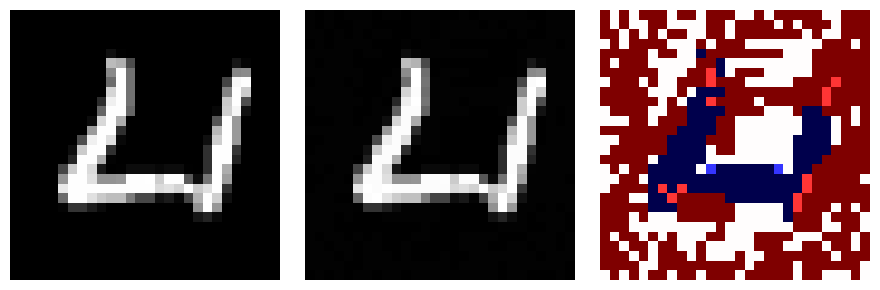


Index: 5 | True label: 4
True lower (TL) = 1.3552 | max other UPPER = 3.7952 | certified = False

class |     LOWER       UPPER    note
----- | ----------  ----------  -----------
    6 |     3.0644      3.7952  violates
    0 |     2.1191      2.8472  violates
    4 |     1.3552      2.1820  TRUE (TL)
    2 |    -0.1297      0.2864  
    5 |    -0.7095     -0.0254  
    8 |    -1.2075     -0.8148  
    7 |    -1.3798     -0.9279  
    9 |    -2.6987     -1.5416  
    1 |    -1.9600     -1.5461  
    3 |    -2.0702     -1.6355  


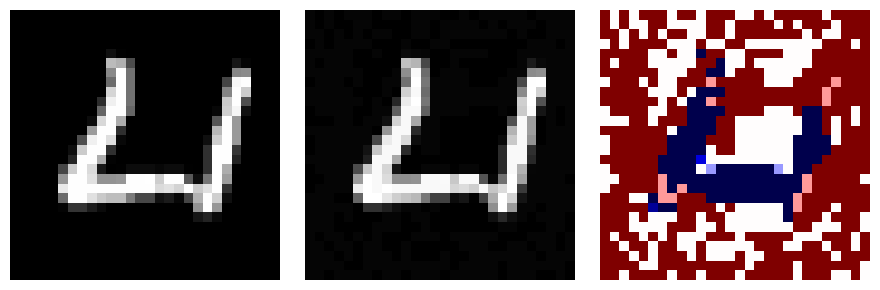


Index: 8 | True label: 4
True lower (TL) = 0.9534 | max other UPPER = 4.1298 | certified = False

class |     LOWER       UPPER    note
----- | ----------  ----------  -----------
    6 |     2.7331      4.1298  violates
    0 |     1.7855      3.1326  violates
    4 |     0.9534      2.5208  TRUE (TL)
    2 |    -0.3067      0.4703  
    5 |    -0.9230      0.3589  
    8 |    -1.3380     -0.5902  
    7 |    -1.6417     -0.7717  
    9 |    -3.1491     -0.9850  
    1 |    -2.1839     -1.3942  
    3 |    -2.2775     -1.4697  


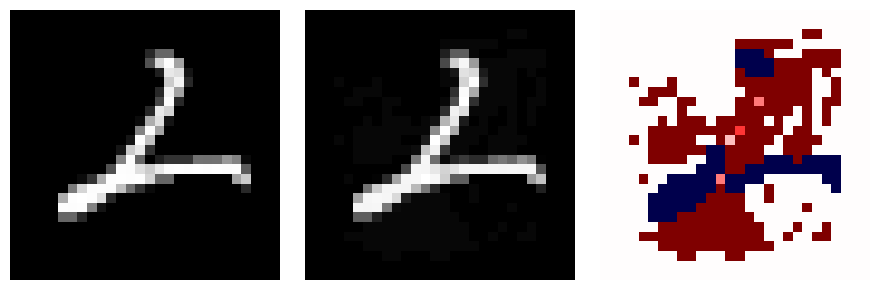


Index: 3 | True label: 2
True lower (TL) = 2.9442 | max other UPPER = 5.7382 | certified = False

class |     LOWER       UPPER    note
----- | ----------  ----------  -----------
    2 |     2.9442      6.3534  TRUE (TL)
    1 |     3.0383      5.7382  violates
    7 |    -0.0530      1.3338  
    3 |    -1.4833      0.9025  
    6 |    -1.0848      0.3114  
    8 |    -0.5431      0.3089  
    5 |    -1.8747     -0.7442  
    0 |    -4.0416     -1.0567  
    4 |    -2.9133     -1.2991  
    9 |    -5.6915     -2.7864  


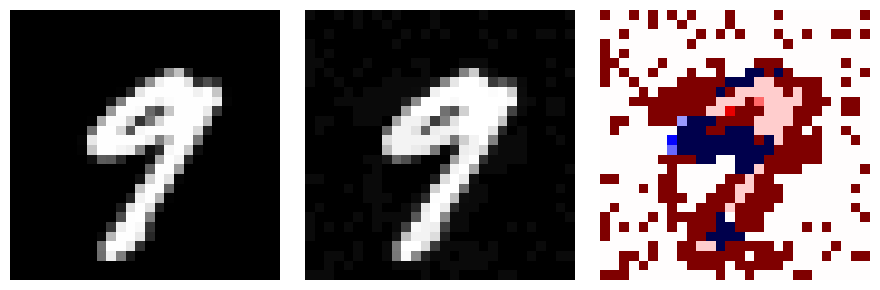


Index: 1 | True label: 9
True lower (TL) = 5.4682 | max other UPPER = 7.1721 | certified = False

class |     LOWER       UPPER    note
----- | ----------  ----------  -----------
    9 |     5.4682      9.2290  TRUE (TL)
    7 |     2.3919      7.1721  violates
    4 |     2.1514      6.6474  violates
    5 |    -0.5245      2.5306  
    3 |    -0.8813      1.9961  
    1 |    -2.2796      1.6933  
    8 |    -2.4759      0.7530  
    2 |    -1.9483      0.1548  
    0 |    -6.5360     -2.3224  
    6 |    -9.1849     -4.0728  


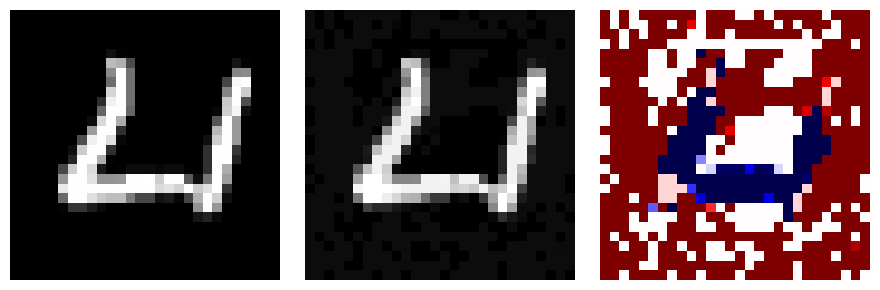


Index: 3 | True label: 4
True lower (TL) = -0.6422 | max other UPPER = 5.3108 | certified = False

class |     LOWER       UPPER    note
----- | ----------  ----------  -----------
    6 |     1.3068      5.3108  violates
    0 |     0.6927      4.0703  violates
    4 |    -0.6422      3.6645  TRUE (TL)
    5 |    -1.5164      1.7948  violates
    2 |    -0.9853      1.2114  violates
    9 |    -4.5862      0.6094  violates
    8 |    -1.7610      0.2972  violates
    7 |    -2.5409     -0.1249  violates
    3 |    -2.9357     -0.7430  
    1 |    -3.3800     -0.8608  


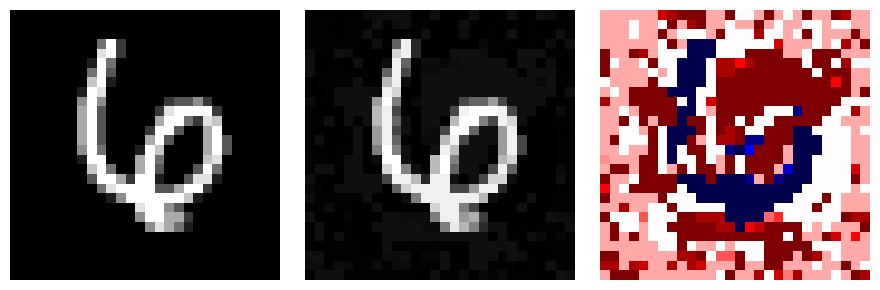


Index: 3 | True label: 6
True lower (TL) = 2.2032 | max other UPPER = 3.9118 | certified = False

class |     LOWER       UPPER    note
----- | ----------  ----------  -----------
    6 |     2.2032      5.3233  TRUE (TL)
    4 |     1.1219      3.9118  violates
    8 |    -0.3985      1.4109  
    2 |    -0.4185      0.8545  
    5 |    -0.9706      0.5217  
    0 |    -1.8328      0.0355  
    1 |    -2.3076     -0.1828  
    3 |    -1.8777     -0.4839  
    7 |    -2.8038     -0.6622  
    9 |    -5.3411     -1.2025  


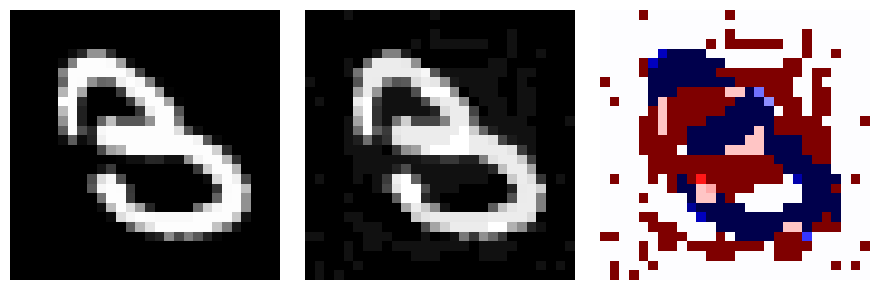


Index: 3 | True label: 3
True lower (TL) = 1.6040 | max other UPPER = 2.2541 | certified = False

class |     LOWER       UPPER    note
----- | ----------  ----------  -----------
    3 |     1.6040      4.6616  TRUE (TL)
    5 |    -0.2858      2.2541  violates
    1 |    -0.9999      2.1832  violates
    2 |    -0.9000      2.0642  violates
    7 |    -1.4437      1.7941  violates
    9 |    -1.7353      1.6572  violates
    8 |    -0.3598      1.4438  
    4 |    -2.5094      0.9509  
    6 |    -5.2469     -0.8288  
    0 |    -5.0007     -1.5304  


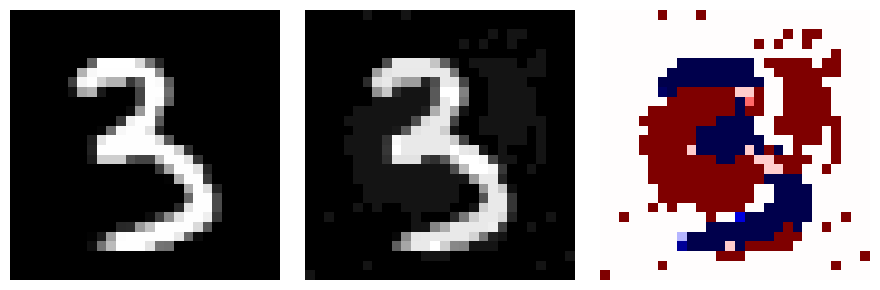


Index: 1 | True label: 3
True lower (TL) = 4.9898 | max other UPPER = 5.5859 | certified = False

class |     LOWER       UPPER    note
----- | ----------  ----------  -----------
    3 |     4.9898      9.6470  TRUE (TL)
    7 |     0.4837      5.5859  violates
    1 |     0.9560      5.2580  violates
    5 |     0.1724      4.2749  
    2 |    -0.4705      3.4870  
    9 |    -3.1793      1.7813  
    4 |    -3.8889      1.1352  
    8 |    -2.2670      0.6357  
    0 |   -11.3728     -4.9532  
    6 |   -12.5389     -5.1945  


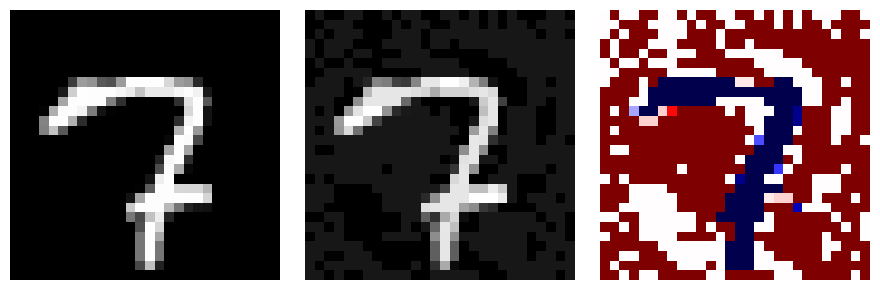


Index: 0 | True label: 7
True lower (TL) = 2.9712 | max other UPPER = 7.2697 | certified = False

class |     LOWER       UPPER    note
----- | ----------  ----------  -----------
    7 |     2.9712     14.3092  TRUE (TL)
    3 |     0.1937      7.2697  violates
    9 |    -2.8467      5.9085  violates
    2 |    -1.4399      5.2537  violates
    1 |    -4.2610      3.0710  violates
    5 |    -2.3776      3.0641  violates
    8 |    -3.4502      2.3904  
    4 |    -8.2990      1.2149  
    0 |    -7.5832      0.7996  
    6 |   -11.0079     -2.3215  


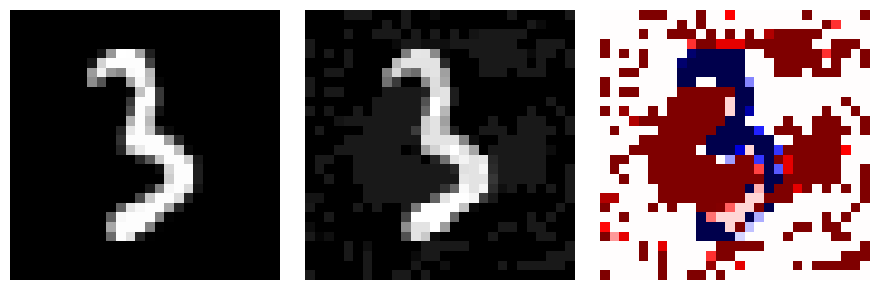


Index: 0 | True label: 3
True lower (TL) = 2.3788 | max other UPPER = 7.1571 | certified = False

class |     LOWER       UPPER    note
----- | ----------  ----------  -----------
    3 |     2.3788      9.4986  TRUE (TL)
    1 |    -0.7070      7.1571  violates
    7 |    -1.4927      6.6548  violates
    5 |    -1.5821      5.4003  violates
    2 |    -1.7887      4.3875  violates
    4 |    -5.7545      2.7973  violates
    9 |    -5.2914      2.6498  violates
    8 |    -3.3619      1.4284  
    6 |   -12.7015     -1.4281  
    0 |   -11.8471     -2.1175  


In [14]:
eps_range = np.linspace(0.01, 0.1, 10)

for epsilon in eps_range:
    images, labels = next(iter(test_loader))
    # Shuffle images and labels in unison
    idx = torch.randperm(images.size(0))
    images = images[idx]
    labels = labels[idx]
    result = analyze_sample(ibp_model, ibp_bounded_net, images, labels, epsilon, device)

    y = int(result["true_label"])
    lower = result["bounds_lower"].detach().cpu().numpy()
    upper = result["bounds_upper"].detach().cpu().numpy()
    tl = float(lower[y])

    order = upper.argsort()[::-1]
    other_upper_max = float(upper[[c for c in range(10) if c != y]].max())
    certified = tl > other_upper_max

    print(f"\nIndex: {result['index']} | True label: {y}")
    print(f"True lower (TL) = {tl:.4f} | max other UPPER = {other_upper_max:.4f} | certified = {certified}")
    print("\nclass |     LOWER       UPPER    note")
    print("----- | ----------  ----------  -----------")
    for c in order:
        note = []
        if c == y:
            note.append("TRUE (TL)")
        if c != y and upper[c] >= tl:
            note.append("violates")
        tag = " ; ".join(note)
        print(f"{c:>5} | {lower[c]:>10.4f}  {upper[c]:>10.4f}  {tag}")
